<a href="https://colab.research.google.com/github/chacha091/ETC/blob/main/Task1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# 나눔고딕 폰트 설치
!sudo apt-get update -qq
!sudo apt-get install -qq fonts-nanum

# matplotlib에 폰트 등록
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

# 설치된 나눔고딕 경로 검색
font_path = "/usr/share/fonts/truetype/nanum/NanumGothic.ttf"

# 폰트 등록
fm.fontManager.addfont(font_path)

# matplotlib 기본 폰트 설정
plt.rc('font', family='NanumGothic')
plt.rcParams['axes.unicode_minus'] = False

W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 78, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
Selecting previously unselected package fonts-nanum.
(Reading database ... 121713 files and directories currently installed.)
Preparing to unpack .../fonts-nanum_20200506-1_all.deb ...
Unpacking fonts-nanum (20200506-1) ...
Setting up fonts-nanum (20200506-1) ...
Processing triggers for fontconfig (2.13.1-4.2ubuntu5) ...


In [ ]:
import os
import random
from IPython.display import display
from PIL import Image

# 이미지가 있는 최상위 폴더 경로
base_path = '/content/drive/MyDrive/Colab Notebooks/비즈니스데이터분석/homework'

In [ ]:
import os
import time
import torch
import torchvision.models as models
import torchvision.transforms as transforms
import pandas as pd
from PIL import Image
from IPython.display import display

#==========================================================
# 1️⃣ GPU 설정
#==========================================================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"[INFO] 현재 사용 중인 디바이스: {device}")

#==========================================================
# 2️⃣ ResNet18 모델 로드 (pretrained + feature extractor)
#==========================================================
print("\n[INFO] ResNet18 모델 로드 중...")
start_time = time.time()

model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
model = torch.nn.Sequential(*list(model.children())[:-1])   # 마지막 FC 제거 → 임베딩 벡터만 추출
model = model.to(device)
model.eval()

print("[SUCCESS] 모델 로드 완료")
print(f"[TIME] 소요 시간: {time.time() - start_time:.2f}초")

#==========================================================
# 3️⃣ 이미지 전처리 정의
#==========================================================
print("\n[INFO] 이미지 전처리기 초기화...")

transform = transforms.Compose([
    transforms.Resize((224, 224)),   # ResNet 입력 사이즈
    transforms.ToTensor(),
    transforms.Normalize(             # ImageNet 평균/표준편차
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    ),
])

print("[SUCCESS] 전처리 설정 완료")

#==========================================================
# 4️⃣ 폴더 스캔 및 파일 리스트 확보
#==========================================================
print("\n[INFO] 폴더 스캔 시작...")

folders = [
    os.path.join(base_path, folder)
    for folder in os.listdir(base_path)
    if os.path.isdir(os.path.join(base_path, folder))
]

print(f"[SUCCESS] 총 {len(folders)}개 폴더 탐색 완료")

# 폴더별 이미지 파일 수 취합
all_image_paths = []
for folder in folders:
    images = [
        os.path.join(folder, f)
        for f in os.listdir(folder)
        if f.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif'))
    ]
    all_image_paths.extend(images)

total_images = len(all_image_paths)
print(f"[INFO] 전체 이미지 개수: {total_images}개")

# 예상 시간: 이미지 1개당 약 0.03~0.06초
estimated_time = total_images * 0.05
print(f"[INFO] 예상 소요 시간: 약 {estimated_time:.1f}초")

#==========================================================
# 5️⃣ 임베딩 수행
#==========================================================
print("\n[INFO] 임베딩 생성 시작...\n")

results = []
start_total_time = time.time()

for idx, img_path in enumerate(all_image_paths):

    # 현재 이미지 진행률 표시
    if idx % 200 == 0:
        elapsed = time.time() - start_total_time
        remaining = estimated_time - elapsed
        print(f"[PROGRESS] {idx}/{total_images} 처리 중... (남은 예상 시간 {remaining:.1f}초)")

    try:
        # 이미지 열기
        img = Image.open(img_path).convert("RGB")
        img_tensor = transform(img).unsqueeze(0).to(device)

        # 임베딩 생성
        with torch.no_grad():
            embedding = model(img_tensor).squeeze().cpu().numpy()  # shape: (512,)

        # 폴더명, 파일명 추출
        folder_name = os.path.basename(os.path.dirname(img_path))
        file_name = os.path.basename(img_path)

        # 결과 저장
        results.append({
            "파일명": file_name,
            "폴더명": folder_name,
            "임베딩값": embedding
        })

    except Exception as e:
        print(f"[ERROR] 이미지 처리 중 오류 발생: {img_path}")
        print(e)

print("\n[SUCCESS] 모든 이미지 임베딩 생성 완료!")
print(f"[TIME] 전체 소요 시간: {time.time() - start_total_time:.2f}초")

#==========================================================
# 6️⃣ DataFrame 생성
#==========================================================
print("\n[INFO] DataFrame 생성 중...")

df = pd.DataFrame(results)

print("[SUCCESS] DataFrame 생성 완료!")
display(df.head())


[INFO] 현재 사용 중인 디바이스: cpu

[INFO] ResNet18 모델 로드 중...
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 184MB/s]


[SUCCESS] 모델 로드 완료
[TIME] 소요 시간: 0.62초

[INFO] 이미지 전처리기 초기화...
[SUCCESS] 전처리 설정 완료

[INFO] 폴더 스캔 시작...
[SUCCESS] 총 10개 폴더 탐색 완료
[INFO] 전체 이미지 개수: 5993개
[INFO] 예상 소요 시간: 약 299.7초

[INFO] 임베딩 생성 시작...

[PROGRESS] 0/5993 처리 중... (남은 예상 시간 299.6초)
[PROGRESS] 200/5993 처리 중... (남은 예상 시간 266.8초)
[PROGRESS] 400/5993 처리 중... (남은 예상 시간 245.6초)
[PROGRESS] 600/5993 처리 중... (남은 예상 시간 225.7초)
[PROGRESS] 800/5993 처리 중... (남은 예상 시간 165.7초)
[PROGRESS] 1000/5993 처리 중... (남은 예상 시간 15.9초)
[PROGRESS] 1200/5993 처리 중... (남은 예상 시간 -133.3초)
[PROGRESS] 1400/5993 처리 중... (남은 예상 시간 -283.2초)
[PROGRESS] 1600/5993 처리 중... (남은 예상 시간 -435.5초)
[PROGRESS] 1800/5993 처리 중... (남은 예상 시간 -588.7초)
[PROGRESS] 2000/5993 처리 중... (남은 예상 시간 -742.4초)
[PROGRESS] 2200/5993 처리 중... (남은 예상 시간 -895.7초)
[PROGRESS] 2400/5993 처리 중... (남은 예상 시간 -1048.2초)
[PROGRESS] 2600/5993 처리 중... (남은 예상 시간 -1201.2초)
[PROGRESS] 2800/5993 처리 중... (남은 예상 시간 -1351.3초)
[PROGRESS] 3000/5993 처리 중... (남은 예상 시간 -1506.0초)
[PROGRESS] 3200/5993 처리 중... (남은 예상 시간 -16

,파일명,폴더명,임베딩값
0,b99dfcd9daacdd996eae61eb3eabf09495ec4a59.jpg,blue_shirt,"[0.12106447, 0.46897772, 0.0151636, 2.5470755,..."
1,b7218269381b0b7848d5f056843864e6c9db1f31.jpg,blue_shirt,"[0.20742136, 1.1933355, 0.23971708, 1.7406274,..."
2,bb53f002d8e27d3b74291f0e7986e490c42ef28d.jpg,blue_shirt,"[0.32315493, 0.65305674, 0.0029351139, 1.95968..."
3,b3432c52ddf06df7dc6b45117364aa2751837a69.jpg,blue_shirt,"[0.5855773, 0.105487674, 0.04469228, 3.3350003..."
4,b9f056291b1bd3eb2416581a2addc7bd14422dee.jpg,blue_shirt,"[0.50517935, 0.18136586, 0.031923562, 3.877263..."


[INFO] DataFrame에서 임베딩 추출 중...
[SUCCESS] 임베딩 배열 생성 완료
[INFO] 임베딩 shape: (5993, 512)

[INFO] t-SNE 모델 초기화 중...
[SUCCESS] t-SNE 초기화 완료

[INFO] t-SNE 변환 시작...
[INFO] 예상 최소 소요 시간: 약 119.9초 (이미지 수에 따라 증가 가능)
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 5993 samples in 0.002s...


/usr/local/lib/python3.12/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


[t-SNE] Computed neighbors for 5993 samples in 2.132s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5993
[t-SNE] Computed conditional probabilities for sample 2000 / 5993
[t-SNE] Computed conditional probabilities for sample 3000 / 5993
[t-SNE] Computed conditional probabilities for sample 4000 / 5993
[t-SNE] Computed conditional probabilities for sample 5000 / 5993
[t-SNE] Computed conditional probabilities for sample 5993 / 5993
[t-SNE] Mean sigma: 4.093083
[t-SNE] KL divergence after 250 iterations with early exaggeration: 76.054810
[t-SNE] KL divergence after 1000 iterations: 1.635089
[SUCCESS] t-SNE 변환 완료
[TIME] 총 소요 시간: 61.9초

[INFO] t-SNE 결과를 DataFrame으로 변환 중...
[SUCCESS] t-SNE DataFrame 생성 완료


,tsne_x,tsne_y,폴더명,파일명
0,-37.986645,52.459976,blue_shirt,b99dfcd9daacdd996eae61eb3eabf09495ec4a59.jpg
1,-42.116402,7.130365,blue_shirt,b7218269381b0b7848d5f056843864e6c9db1f31.jpg
2,-39.056011,38.767273,blue_shirt,bb53f002d8e27d3b74291f0e7986e490c42ef28d.jpg
3,-42.718979,52.733677,blue_shirt,b3432c52ddf06df7dc6b45117364aa2751837a69.jpg
4,-35.553898,44.956543,blue_shirt,b9f056291b1bd3eb2416581a2addc7bd14422dee.jpg



[INFO] t-SNE 시각화 중...


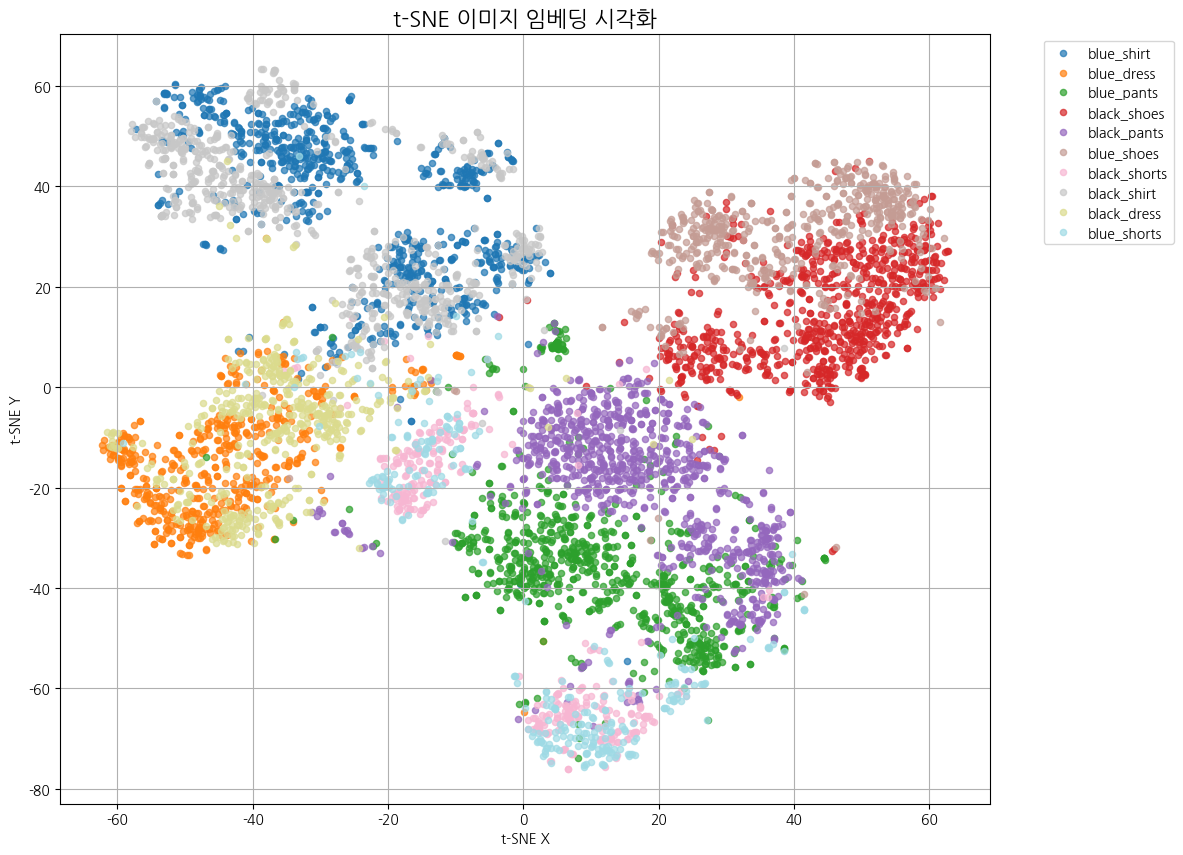

[SUCCESS] t-SNE 시각화 완료!


In [ ]:
import numpy as np
import pandas as pd
import time
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

#==========================================================
# 1️⃣ 임베딩 데이터 준비
#==========================================================
print("[INFO] DataFrame에서 임베딩 추출 중...")

embeddings = np.vstack(df["임베딩값"].values)  # (N, 512)
labels = df["폴더명"].values                 # 색상 구분용

print("[SUCCESS] 임베딩 배열 생성 완료")
print(f"[INFO] 임베딩 shape: {embeddings.shape}")

#==========================================================
# 2️⃣ t-SNE 모델 초기화
#==========================================================
print("\n[INFO] t-SNE 모델 초기화 중...")
tsne = TSNE(
    n_components=2,
    perplexity=30,
    n_iter=1000,
    random_state=42,
    verbose=1
)
print("[SUCCESS] t-SNE 초기화 완료")

#==========================================================
# 3️⃣ t-SNE 학습 (가장 오래 걸리는 과정)
#==========================================================
print("\n[INFO] t-SNE 변환 시작...")
start_time = time.time()

expected_min = embeddings.shape[0] * 0.02
print(f"[INFO] 예상 최소 소요 시간: 약 {expected_min:.1f}초 (이미지 수에 따라 증가 가능)")

tsne_result = tsne.fit_transform(embeddings)

print("[SUCCESS] t-SNE 변환 완료")
print(f"[TIME] 총 소요 시간: {time.time() - start_time:.1f}초")

#==========================================================
# 4️⃣ t-SNE 결과를 DataFrame으로 변환
#==========================================================
print("\n[INFO] t-SNE 결과를 DataFrame으로 변환 중...")

tsne_df = pd.DataFrame({
    "tsne_x": tsne_result[:, 0],
    "tsne_y": tsne_result[:, 1],
    "폴더명": labels,
    "파일명": df["파일명"]
})

print("[SUCCESS] t-SNE DataFrame 생성 완료")
display(tsne_df.head())

#==========================================================
# 5️⃣ Plot 시각화
#==========================================================
print("\n[INFO] t-SNE 시각화 중...")

plt.figure(figsize=(12, 10))

# 폴더명으로 색상 구분
unique_labels = tsne_df["폴더명"].unique()
colors = plt.cm.tab20(np.linspace(0, 1, len(unique_labels)))

for label, color in zip(unique_labels, colors):
    subset = tsne_df[tsne_df["폴더명"] == label]
    plt.scatter(
        subset["tsne_x"],
        subset["tsne_y"],
        s=20,
        color=color,
        label=label,
        alpha=0.7
    )

plt.title("t-SNE 이미지 임베딩 시각화", fontsize=16)
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
plt.xlabel("t-SNE X")
plt.ylabel("t-SNE Y")
plt.grid(True)
plt.show()

print("[SUCCESS] t-SNE 시각화 완료!")


[INFO] 임베딩 데이터와 레이블 준비 중...
[SUCCESS] 임베딩 데이터 (X) 및 원본 레이블 (y_raw) 준비 완료
[INFO] 데이터 X shape: (5993, 512), 레이블 y_raw shape: (5993,)

[INFO] 레이블 인코딩 진행 중...
[SUCCESS] 레이블 인코딩 완료
[INFO] 인코딩 결과:
  0: black_dress
  1: black_pants
  2: black_shirt
  3: black_shoes
  4: black_shorts
  5: blue_dress
  6: blue_pants
  7: blue_shirt
  8: blue_shoes
  9: blue_shorts
[INFO] 인코딩된 레이블 y shape: (5993,)

[INFO] 학습용/테스트용 데이터 분할 중 (test_size=20%)...
[SUCCESS] 데이터 분할 완료
[INFO] 학습 데이터 개수: 4794, 테스트 데이터 개수: 1199

[INFO] 랜덤 포레스트 분류 모델 학습 시작...
[SUCCESS] 랜덤 포레스트 모델 학습 완료
[TIME] 학습 소요 시간: 20.05초

[INFO] 테스트 데이터로 예측 수행 중...
[SUCCESS] 예측 수행 완료

[INFO] 모델 성능 평가 결과:
✅ 최종 정확도 (Accuracy): 0.8924

--- 종합 분류 리포트 (Classification Report) ---
              precision    recall  f1-score   support

 black_dress       0.87      0.87      0.87        90
 black_pants       0.87      0.90      0.88       174
 black_shirt       0.93      0.95      0.94       143
 black_shoes       0.90      0.90      0.90       153
black_short

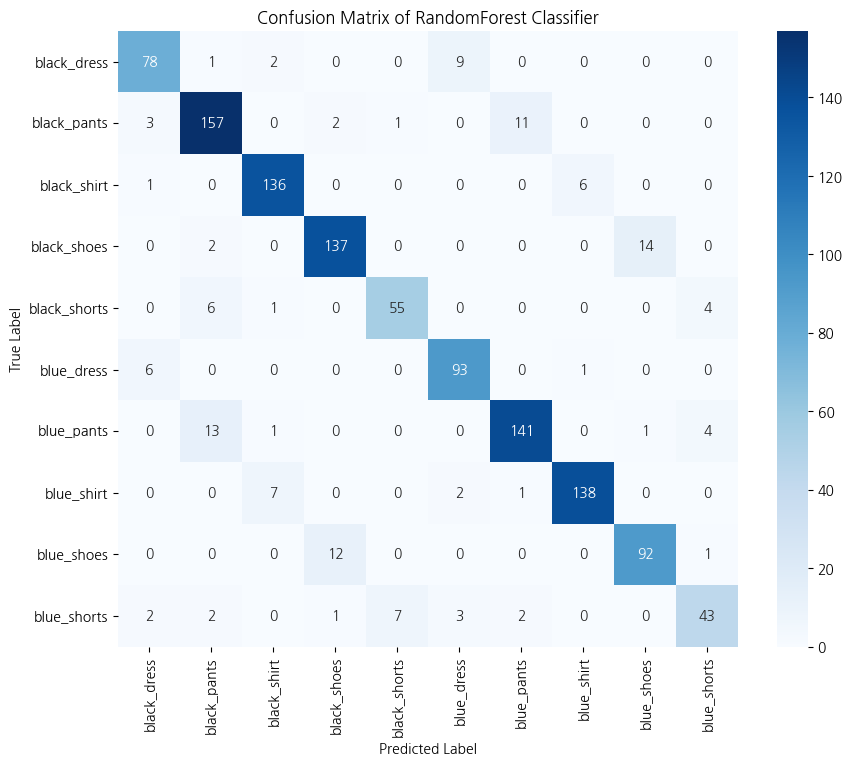

[SUCCESS] 혼동 행렬 시각화 완료!


In [ ]:
import numpy as np
import pandas as pd
import time
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt

#==========================================================
# 1️⃣ 임베딩 데이터 및 레이블 준비
#==========================================================
print("[INFO] 임베딩 데이터와 레이블 준비 중...")

# ResNet18 임베딩 (512차원)
X = np.vstack(df["임베딩값"].values)

# 상품 카테고리 레이블 (폴더명)
y_raw = df["폴더명"].values

print("[SUCCESS] 임베딩 데이터 (X) 및 원본 레이블 (y_raw) 준비 완료")
print(f"[INFO] 데이터 X shape: {X.shape}, 레이블 y_raw shape: {y_raw.shape}")

#==========================================================
# 2️⃣ 레이블 인코딩
#==========================================================
# 문자열 레이블을 모델 학습용 숫자 형태로 변환
print("\n[INFO] 레이블 인코딩 진행 중...")
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y_raw)
print("[SUCCESS] 레이블 인코딩 완료")

# 인코딩된 레이블과 원본 레이블 매핑 확인
print("[INFO] 인코딩 결과:")
for i, label in enumerate(label_encoder.classes_):
    print(f"  {i}: {label}")
print(f"[INFO] 인코딩된 레이블 y shape: {y.shape}")

#==========================================================
# 3️⃣ 학습용 및 테스트용 데이터 분할
#==========================================================
print("\n[INFO] 학습용/테스트용 데이터 분할 중 (test_size=20%)...")
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
print("[SUCCESS] 데이터 분할 완료")
print(f"[INFO] 학습 데이터 개수: {len(X_train)}, 테스트 데이터 개수: {len(X_test)}")

#==========================================================
# 4️⃣ 랜덤 포레스트 분류 모델 학습
#==========================================================
print("\n[INFO] 랜덤 포레스트 분류 모델 학습 시작...")
start_time = time.time()

# n_estimators: 사용할 결정 트리의 개수
# random_state: 재현성을 위한 시드값
rf_model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
rf_model.fit(X_train, y_train)

print("[SUCCESS] 랜덤 포레스트 모델 학습 완료")
print(f"[TIME] 학습 소요 시간: {time.time() - start_time:.2f}초")

#==========================================================
# 5️⃣ 테스트 데이터로 예측 수행
#==========================================================
print("\n[INFO] 테스트 데이터로 예측 수행 중...")
y_pred = rf_model.predict(X_test)
print("[SUCCESS] 예측 수행 완료")

#==========================================================
# 6️⃣ 모델 성능 평가 및 결과 출력
#==========================================================
print("\n[INFO] 모델 성능 평가 결과:")

# 6-1. 정확도 (Accuracy)
accuracy = accuracy_score(y_test, y_pred)
print(f"✅ 최종 정확도 (Accuracy): {accuracy:.4f}")

# 6-2. 종합 분류 리포트 (Precision, Recall, F1-Score)
target_names = label_encoder.classes_ # 원본 카테고리 이름 사용
print("\n--- 종합 분류 리포트 (Classification Report) ---")
print(classification_report(y_test, y_pred, target_names=target_names))

# 6-3. 혼동 행렬 시각화 (Confusion Matrix)
print("\n[INFO] 혼동 행렬 시각화 중...")
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=target_names,
    yticklabels=target_names
)
plt.title("Confusion Matrix of RandomForest Classifier")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()
print("[SUCCESS] 혼동 행렬 시각화 완료!")

In [ ]:
import numpy as np
import pandas as pd
import time
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score

#==========================================================
# 0️⃣ 기존 데이터 재확인 (이전 단계 결과 사용)
#==========================================================
print("[INFO] 기존 임베딩 데이터 및 레이블 확인 중...")
# 이전 단계에서 준비된 df DataFrame 사용
X = np.vstack(df["임베딩값"].values)
y_raw = df["폴더명"].values

# 레이블 인코딩 재적용
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y_raw)
target_names = label_encoder.classes_

print("[SUCCESS] 데이터 준비 완료")

#==========================================================
# 1️⃣ 데이터 분할: Train (70%) / Validation (20%) / Test (10%)
#==========================================================
print("\n[INFO] 데이터 분할 시작 (Train: 70%, Validation: 20%, Test: 10%)...")
start_time = time.time()

# 1단계: X_train_val (90%)와 X_test (10%)로 분할
X_train_val, X_test, y_train_val, y_test = train_test_split(
    X, y, test_size=0.1, random_state=42, stratify=y
)

# 2단계: X_train_val (90%)를 X_train (70%)와 X_val (20%)로 분할
# 90% 중 약 2/9가 20%에 해당함 → 0.2 / 0.9 = 0.2222...
test_size_for_val = 0.2 / 0.9

X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=test_size_for_val, random_state=42, stratify=y_train_val
)

print("[SUCCESS] 데이터 분할 완료")
print(f"[INFO] 학습 데이터 개수 (Train): {len(X_train)} ({len(X_train)/len(X):.2f})")
print(f"[INFO] 검증 데이터 개수 (Validation): {len(X_val)} ({len(X_val)/len(X):.2f})")
print(f"[INFO] 테스트 데이터 개수 (Test): {len(X_test)} ({len(X_test)/len(X):.2f})")
print(f"[TIME] 데이터 분할 소요 시간: {time.time() - start_time:.2f}초")

#==========================================================
# 2️⃣ 하이퍼파라미터 튜닝 및 모델 평가 함수 정의
#==========================================================
def tune_and_evaluate_model(model_class, param_grid, model_name, X_train, y_train, X_test, y_test, target_names):
    """
    GridSearchCV를 사용하여 최적 하이퍼파라미터를 찾고,
    최종 모델을 테스트 세트로 평가하는 함수
    """
    print(f"\n[{model_name} TUNE] 하이퍼파라미터 튜닝 시작 (Grid Search)...")
    tune_start_time = time.time()

    # GridSearchCV 설정 (cv=5, 5-Fold 교차 검증 사용)
    grid_search = GridSearchCV(
        model_class,
        param_grid,
        cv=5,
        scoring='accuracy',
        n_jobs=-1,
        verbose=1
    )

    # Grid Search를 학습 데이터로 훈련 (Grid Search 내부적으로 Train/Validation을 나눔)
    grid_search.fit(X_train, y_train)

    print(f"[SUCCESS] {model_name} 하이퍼파라미터 튜닝 완료")
    print(f"[TIME] 튜닝 소요 시간: {time.time() - tune_start_time:.2f}초")

    best_params = grid_search.best_params_
    print(f"[{model_name} TUNE] 최적 하이퍼파라미터: {best_params}")

    # 최적 모델을 사용하여 최종 테스트 세트 예측
    best_model = grid_search.best_estimator_
    print(f"\n[{model_name} EVAL] 최종 테스트 세트 예측 시작...")
    y_pred = best_model.predict(X_test)
    print("[SUCCESS] 최종 테스트 세트 예측 완료")

    # 최종 성능 평가
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred, target_names=target_names)

    print(f"\n--- 📊 {model_name} 최종 테스트 성능 평가 ---")
    print(f"✅ 테스트 정확도 (Test Accuracy): {accuracy:.4f}")
    print("\n--- 클래스별 정밀도, 재현율, F1 점수 ---")
    print(report)
    print(f"------------------------------------------")

    return best_model, accuracy, report

#==========================================================
# 3️⃣ 로지스틱 회귀 모델 튜닝 및 평가
#==========================================================
# C (규제 강도의 역수) 파라미터 튜닝
logreg_param_grid = {
    'C': [0.1, 1, 10],
    'solver': ['liblinear']
}

logreg_best_model, logreg_acc, logreg_report = tune_and_evaluate_model(
    LogisticRegression(max_iter=1000, random_state=42), # 최대 반복 횟수 설정
    logreg_param_grid,
    "LOGISTIC REGRESSION",
    X_train, y_train, X_test, y_test, target_names
)

#==========================================================
# 4️⃣ SVM 모델 튜닝 및 평가
#==========================================================
# C (오차 비용) 및 kernel 파라미터 튜닝
svm_param_grid = {
    'C': [0.1, 1],
    'kernel': ['rbf', 'linear']
}

svm_best_model, svm_acc, svm_report = tune_and_evaluate_model(
    SVC(random_state=42),
    svm_param_grid,
    "SVM",
    X_train, y_train, X_test, y_test, target_names
)

#==========================================================
# 5️⃣ 최종 비교 요약
#==========================================================
print("\n" + "="*50)
print("             🔍 최종 모델 성능 비교 요약 (Test Set)")
print("="*50)

comparison_data = {
    "모델": ["Logistic Regression", "SVM"],
    "최적 하이퍼파라미터": [logreg_best_model.get_params(), svm_best_model.get_params()],
    "테스트 정확도": [logreg_acc, svm_acc],
}

# DataFrame 생성 후 정확도 기준으로 정렬하여 출력
comparison_df = pd.DataFrame(comparison_data).sort_values(by="테스트 정확도", ascending=False)

print(comparison_df.to_markdown(index=False, floatfmt=".4f"))
print("\n[SUCCESS] 로지스틱 회귀 및 SVM 모델 튜닝 및 최종 평가 완료")

[INFO] 기존 임베딩 데이터 및 레이블 확인 중...
[SUCCESS] 데이터 준비 완료

[INFO] 데이터 분할 시작 (Train: 70%, Validation: 20%, Test: 10%)...
[SUCCESS] 데이터 분할 완료
[INFO] 학습 데이터 개수 (Train): 4194 (0.70)
[INFO] 검증 데이터 개수 (Validation): 1199 (0.20)
[INFO] 테스트 데이터 개수 (Test): 600 (0.10)
[TIME] 데이터 분할 소요 시간: 0.02초

[LOGISTIC REGRESSION TUNE] 하이퍼파라미터 튜닝 시작 (Grid Search)...
Fitting 5 folds for each of 3 candidates, totalling 15 fits
[SUCCESS] LOGISTIC REGRESSION 하이퍼파라미터 튜닝 완료
[TIME] 튜닝 소요 시간: 111.74초
[LOGISTIC REGRESSION TUNE] 최적 하이퍼파라미터: {'C': 0.1, 'solver': 'liblinear'}

[LOGISTIC REGRESSION EVAL] 최종 테스트 세트 예측 시작...
[SUCCESS] 최종 테스트 세트 예측 완료

--- 📊 LOGISTIC REGRESSION 최종 테스트 성능 평가 ---
✅ 테스트 정확도 (Test Accuracy): 0.9333

--- 클래스별 정밀도, 재현율, F1 점수 ---
              precision    recall  f1-score   support

 black_dress       0.98      0.98      0.98        45
 black_pants       0.92      0.92      0.92        87
 black_shirt       0.95      0.96      0.95        72
 black_shoes       0.95      0.92      0.93        77
black_sh

[INFO] SVM 모델로 테스트 세트 예측을 다시 수행하여 y_pred를 갱신합니다...
[SUCCESS] y_pred 갱신 완료
[INFO] 갱신된 y_test 샘플 수: 600
[INFO] 갱신된 y_pred 샘플 수: 600

[INFO] 혼동 행렬 계산 중...
[SUCCESS] 혼동 행렬 계산 완료

[INFO] 혼동 행렬 시각화 (Heatmap) 시작...


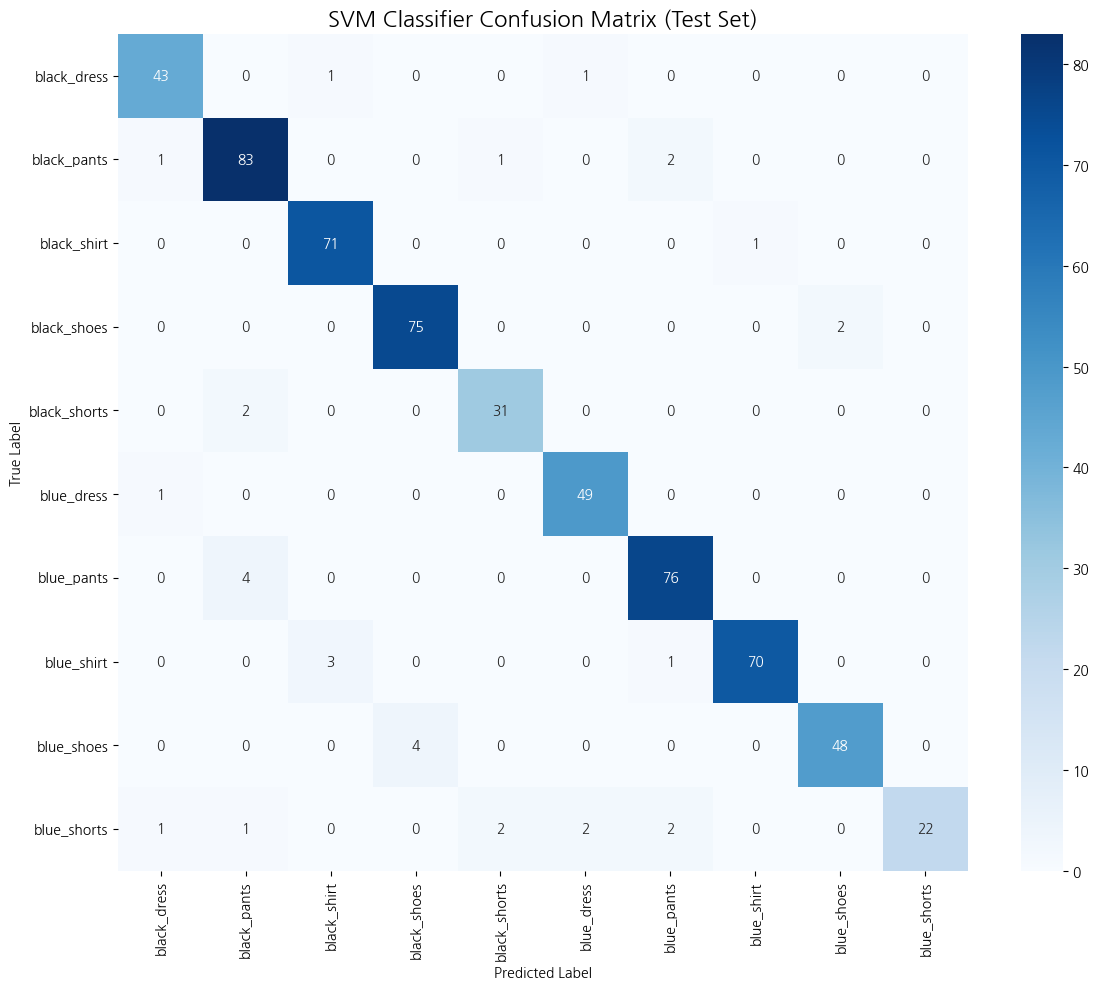

[SUCCESS] 혼동 행렬 시각화 완료!


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

#==========================================================
# 1️⃣ y_pred 변수 재정의 (현재 Test Set 크기(600)에 맞게 예측 재수행)
#==========================================================
print("[INFO] SVM 모델로 테스트 세트 예측을 다시 수행하여 y_pred를 갱신합니다...")

# 'svm_best_model'은 이전 단계에서 최적화된 모델로 가정합니다.
# 'X_test'는 현재 600개의 샘플을 가진 테스트 데이터의 특징 벡터입니다.
y_pred = svm_best_model.predict(X_test)

print("[SUCCESS] y_pred 갱신 완료")
print(f"[INFO] 갱신된 y_test 샘플 수: {len(y_test)}")
print(f"[INFO] 갱신된 y_pred 샘플 수: {len(y_pred)}")

#==========================================================
# 2️⃣ 혼동 행렬 계산 및 시각화
#==========================================================
print("\n[INFO] 혼동 행렬 계산 중...")
# 이제 y_test와 y_pred의 크기가 600개로 일치합니다.
cm = confusion_matrix(y_test, y_pred)
print("[SUCCESS] 혼동 행렬 계산 완료")

print("\n[INFO] 혼동 행렬 시각화 (Heatmap) 시작...")

# target_names: 레이블 인코더에서 얻은 원본 카테고리 이름 (이전 단계에서 정의됨)

plt.figure(figsize=(12, 10))

sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=target_names,
    yticklabels=target_names
)

plt.title("SVM Classifier Confusion Matrix (Test Set)", fontsize=16)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

print("[SUCCESS] 혼동 행렬 시각화 완료!")